<a href="https://colab.research.google.com/github/shreyaporwal19/stock_price_prediction/blob/main/SPP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip3 install yfinance

In [3]:
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import numpy as np
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from statsmodels.tools.sm_exceptions import ValueWarning, HessianInversionWarning, ConvergenceWarning
import warnings

warnings.filterwarnings('ignore', category=ValueWarning)
warnings.filterwarnings('ignore', category=HessianInversionWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)

In [6]:
#BUY OR SELL GRAPH

In [8]:
def run_simulation(returns, prices, amt, order, thresh, verbose=False, plot=True):
    if type(order) == float:
        thresh = None

    curr_holding = False
    events_list = []
    init_amt = amt

    #go through dates
    for date, r in tqdm (returns.iloc[14:].items(), total=len(returns.iloc[14:])):
        #if you're currently holding the stock, sell it
        if curr_holding:
            sell_price = prices.loc[date]
            curr_holding=False
            ret = (sell_price-buy_price)/buy_price
            amt *= (1+ret)
            events_list.append(('s', date, ret))

            if verbose:
                print('Sold at $%s'%sell_price)
                print('Predicted Return: %s'%round(pred,4))
                print('Actual Return: %s'%(round(ret, 4)))
                print('=======================================')
            continue

        #get data til just before current date
        curr_data = returns[:date]

        if type(order) == tuple:
            try:
                #fit model
                model = ARIMA(curr_data, order=order).fit(maxiter=200)

                #get forecast
                pred = model.forecast()[0][0]

            except:
                pred = thresh - 1



        #if you predict a high enough return and not holding, buy it
        if (not curr_holding) and \
        ((type(order) == float and np.random.random() < order)
         or (type(order) == tuple and pred > thresh)
         or (order == 'last' and curr_data[-1] > 0)):

            curr_holding = True
            buy_price = prices.loc[date]
            events_list.append(('b', date))
            if verbose:
                print('Bought at $%s'%buy_price)

    if verbose:
        print('Total Amount: $%s'%round(amt,2))

    #graph
    if plot:

        plt.figure(figsize=(30,12))
        plt.plot(prices[14:])

        y_lims = (int(prices.min()*.95), int(prices.max()*1.05))
        shaded_y_lims = int(prices.min()*.5), int(prices.max()*1.5)

        for idx, event in enumerate(events_list):
            plt.axvline(event[1], color='black', linestyle='--', alpha=0.4)
            if event[0] == 's':
                color = 'blue' if event[2] > 0 else 'red'
                plt.fill_betweenx(range(*shaded_y_lims),
                                  event[1], events_list[idx-1][1], color=color, alpha=0.1)

        tot_return = round(100*(amt / init_amt - 1), 2)
        tot_return = str(tot_return) + '%'
        plt.title("%s Price Data\nThresh=%s\nTotal Amt: $%s\nTotal Return: %s"%(tickerSymbol, thresh, round(amt,2), tot_return), fontsize=20)
        plt.ylim(*y_lims)
        plt.show()

    return amt

In [9]:
tickerSymbol = 'TSLA'
data = yf.Ticker(tickerSymbol)

In [10]:
prices = data.history(start='2021-05-19', end='2022-05-19').Close                                     #Last 1 yr Data
returns = prices.pct_change().dropna()

Text(0, 0.5, 'Prices')

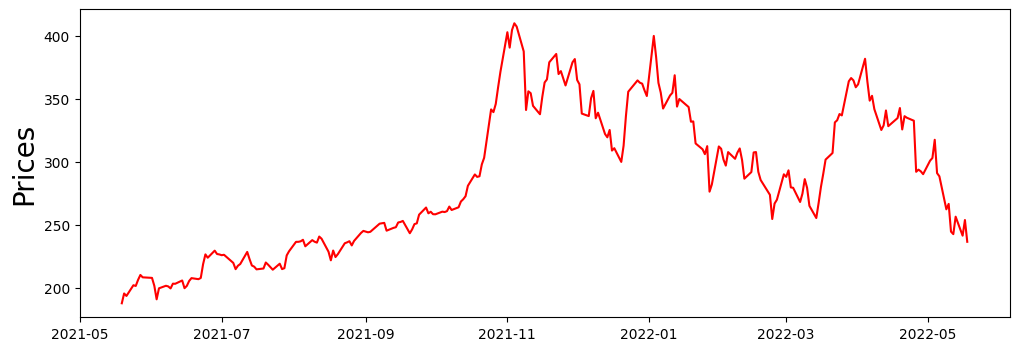

In [11]:
plt.figure(figsize=(12,4))
plt.plot(prices,color='red')
plt.ylabel('Prices', fontsize=20)

Text(0, 0.5, 'Return')

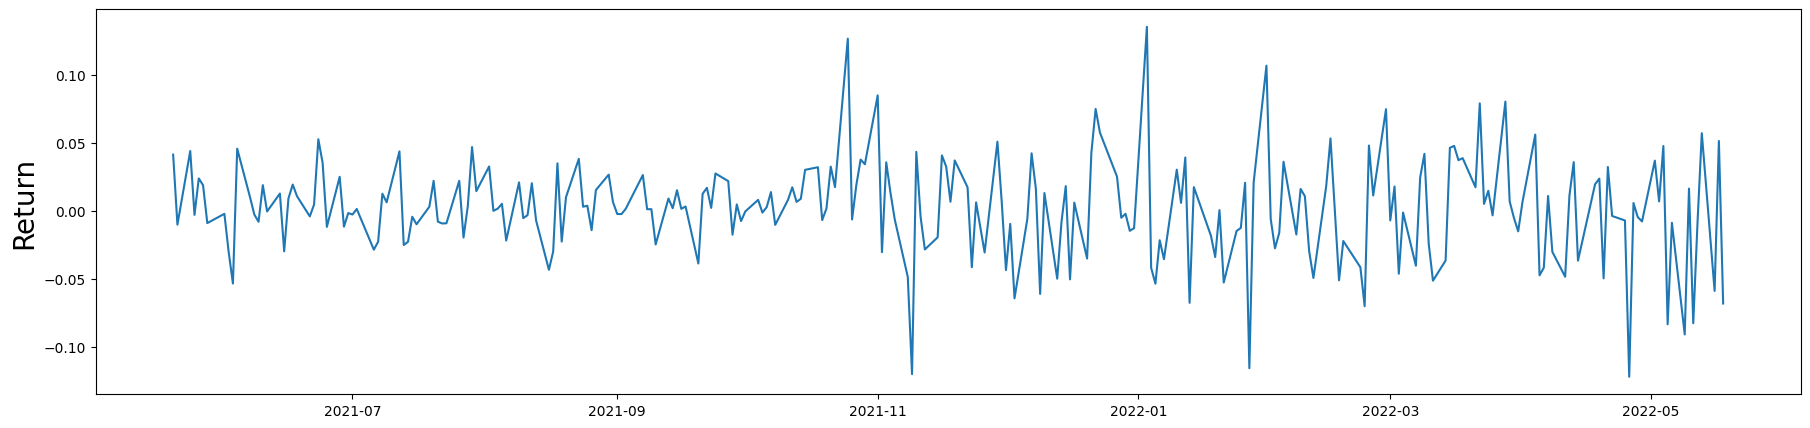

In [12]:
plt.figure(figsize=(22,5))
plt.plot(returns)
plt.ylabel('Return', fontsize=20)

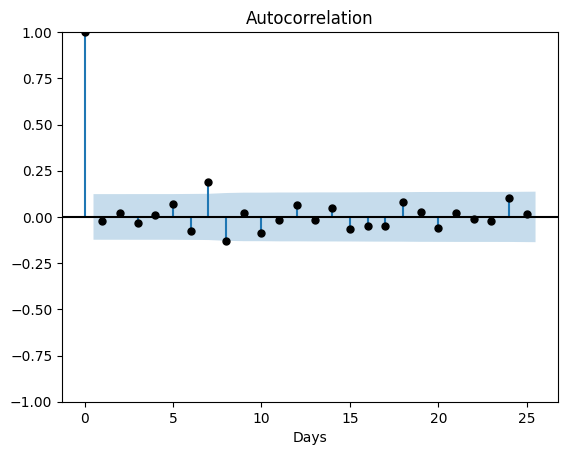

In [13]:
plot_acf(returns,color='black')
plt.xlabel('Days')
plt.show()

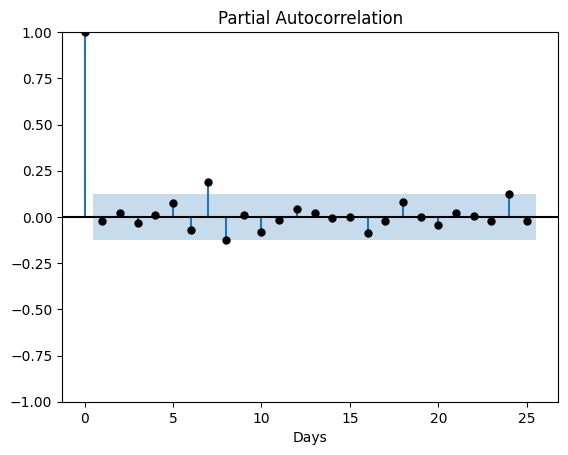

In [14]:
plot_pacf(returns,color='black')                                             #take the value of x where the dot first touches the extremum
plt.xlabel('Days')
plt.show()

100%|██████████| 238/238 [00:00<00:00, 6354.84it/s]


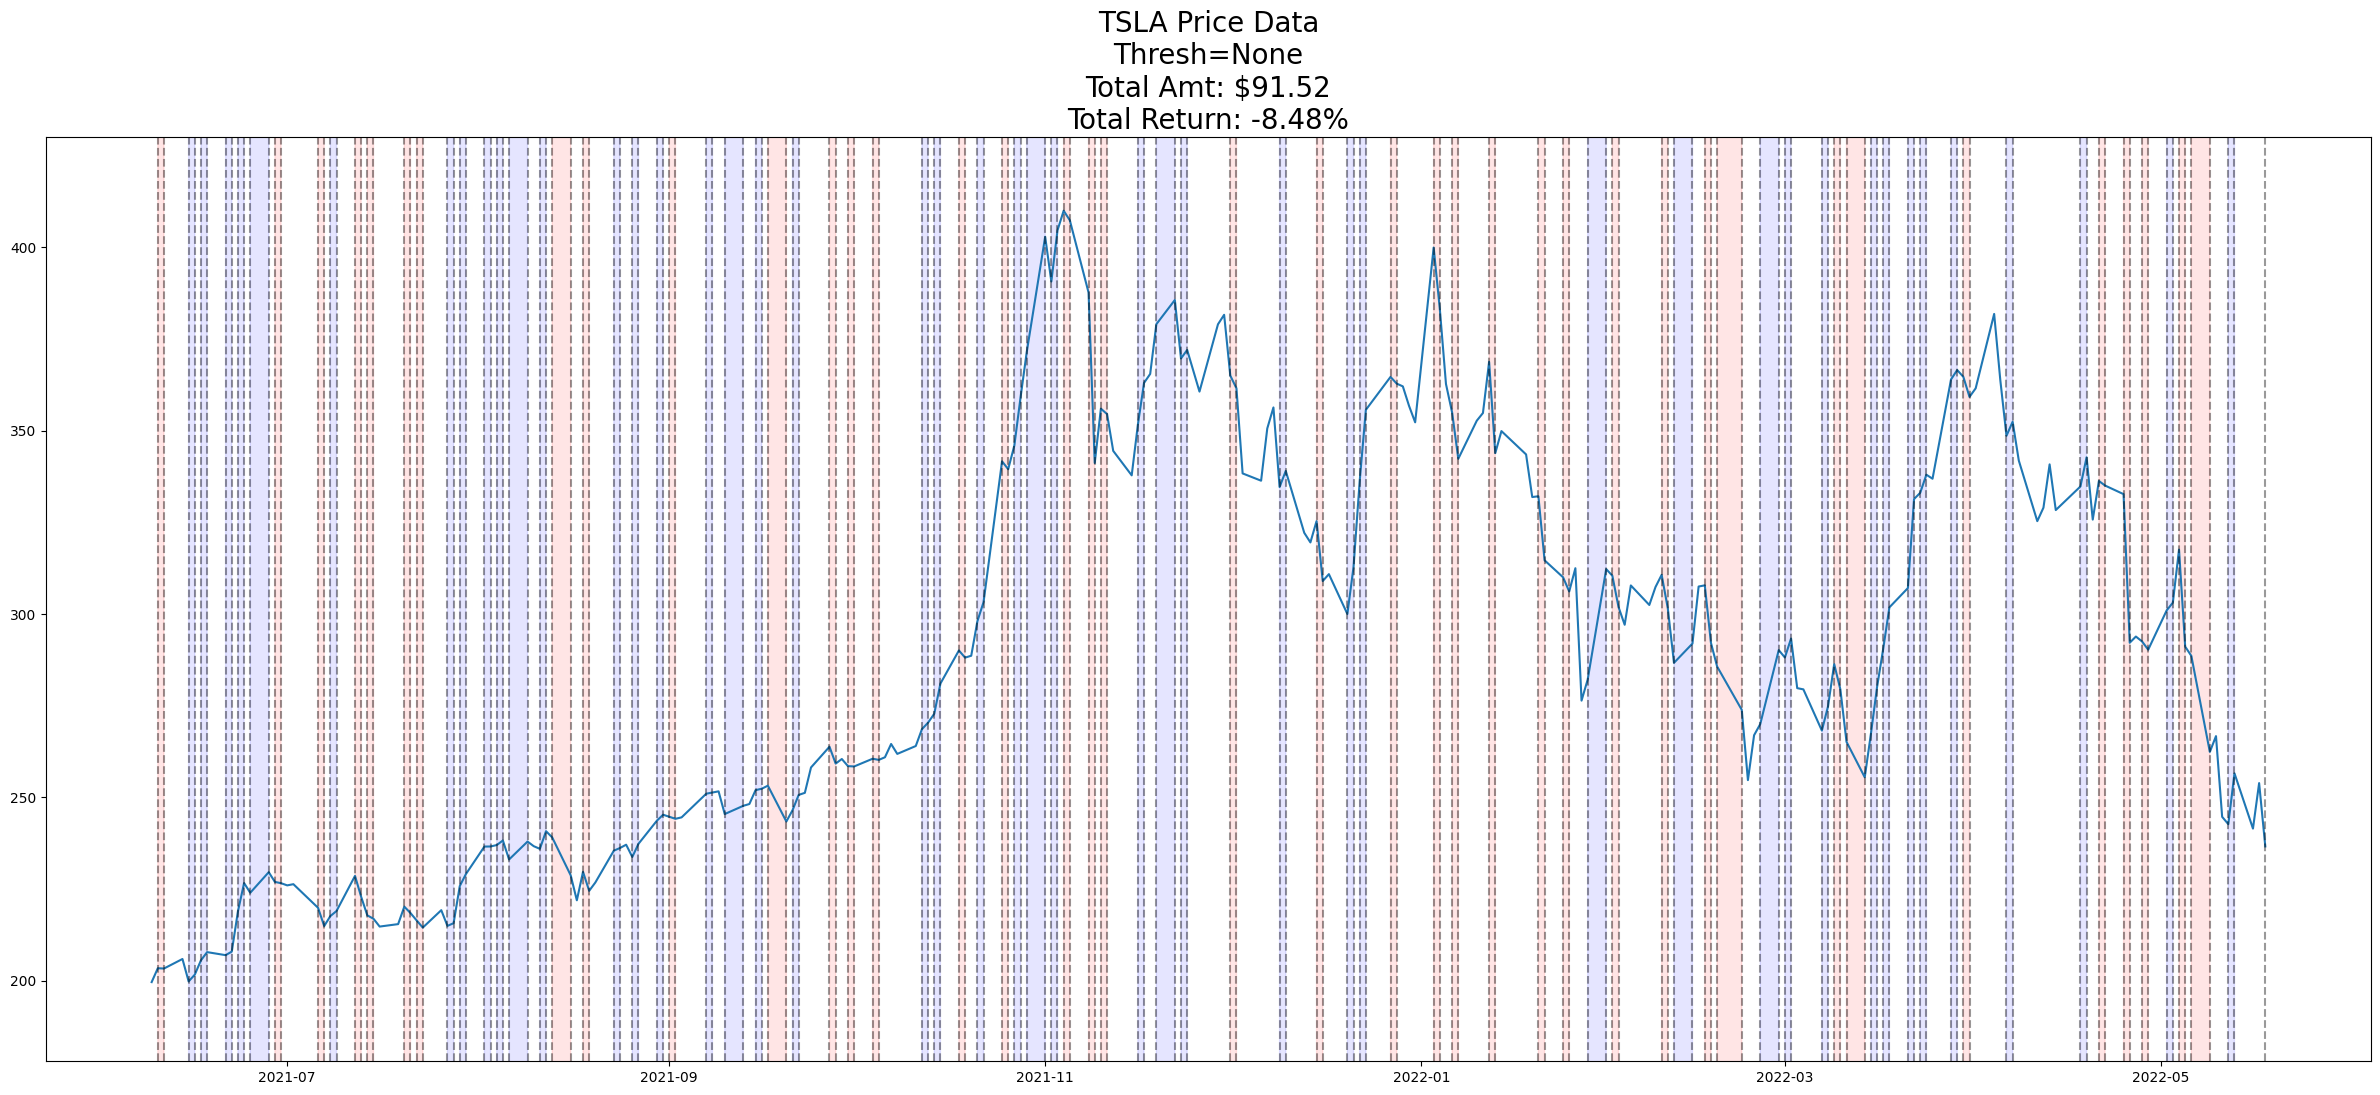

91.52096026699546

In [15]:
run_simulation(returns, prices, 100, 0.5, None,verbose=False)

In [16]:
final_amts = [run_simulation(returns, prices, 100, 0.5, None, verbose=False, plot=False) for _ in range(1000)]

100%|██████████| 238/238 [00:00<00:00, 7235.23it/s]


<ipython-input-17-1f41bfc6d5a0>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(final_amts)


TypeError: ignored

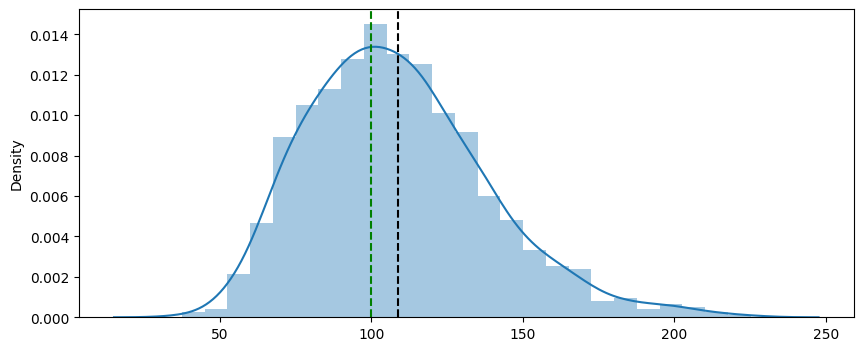

In [17]:
plt.figure(figsize=(10,4))
sns.distplot(final_amts)
plt.axvline(np.mean(final_amts), color='black', linestyle='--')
plt.axvline(100, color='green', linestyle='--')
plt.title('Avg: %s'%(round(np.mean(final_amts),2), round(np.std(final_amts),2)), fontsize=20)

100%|██████████| 238/238 [00:00<00:00, 9131.15it/s]


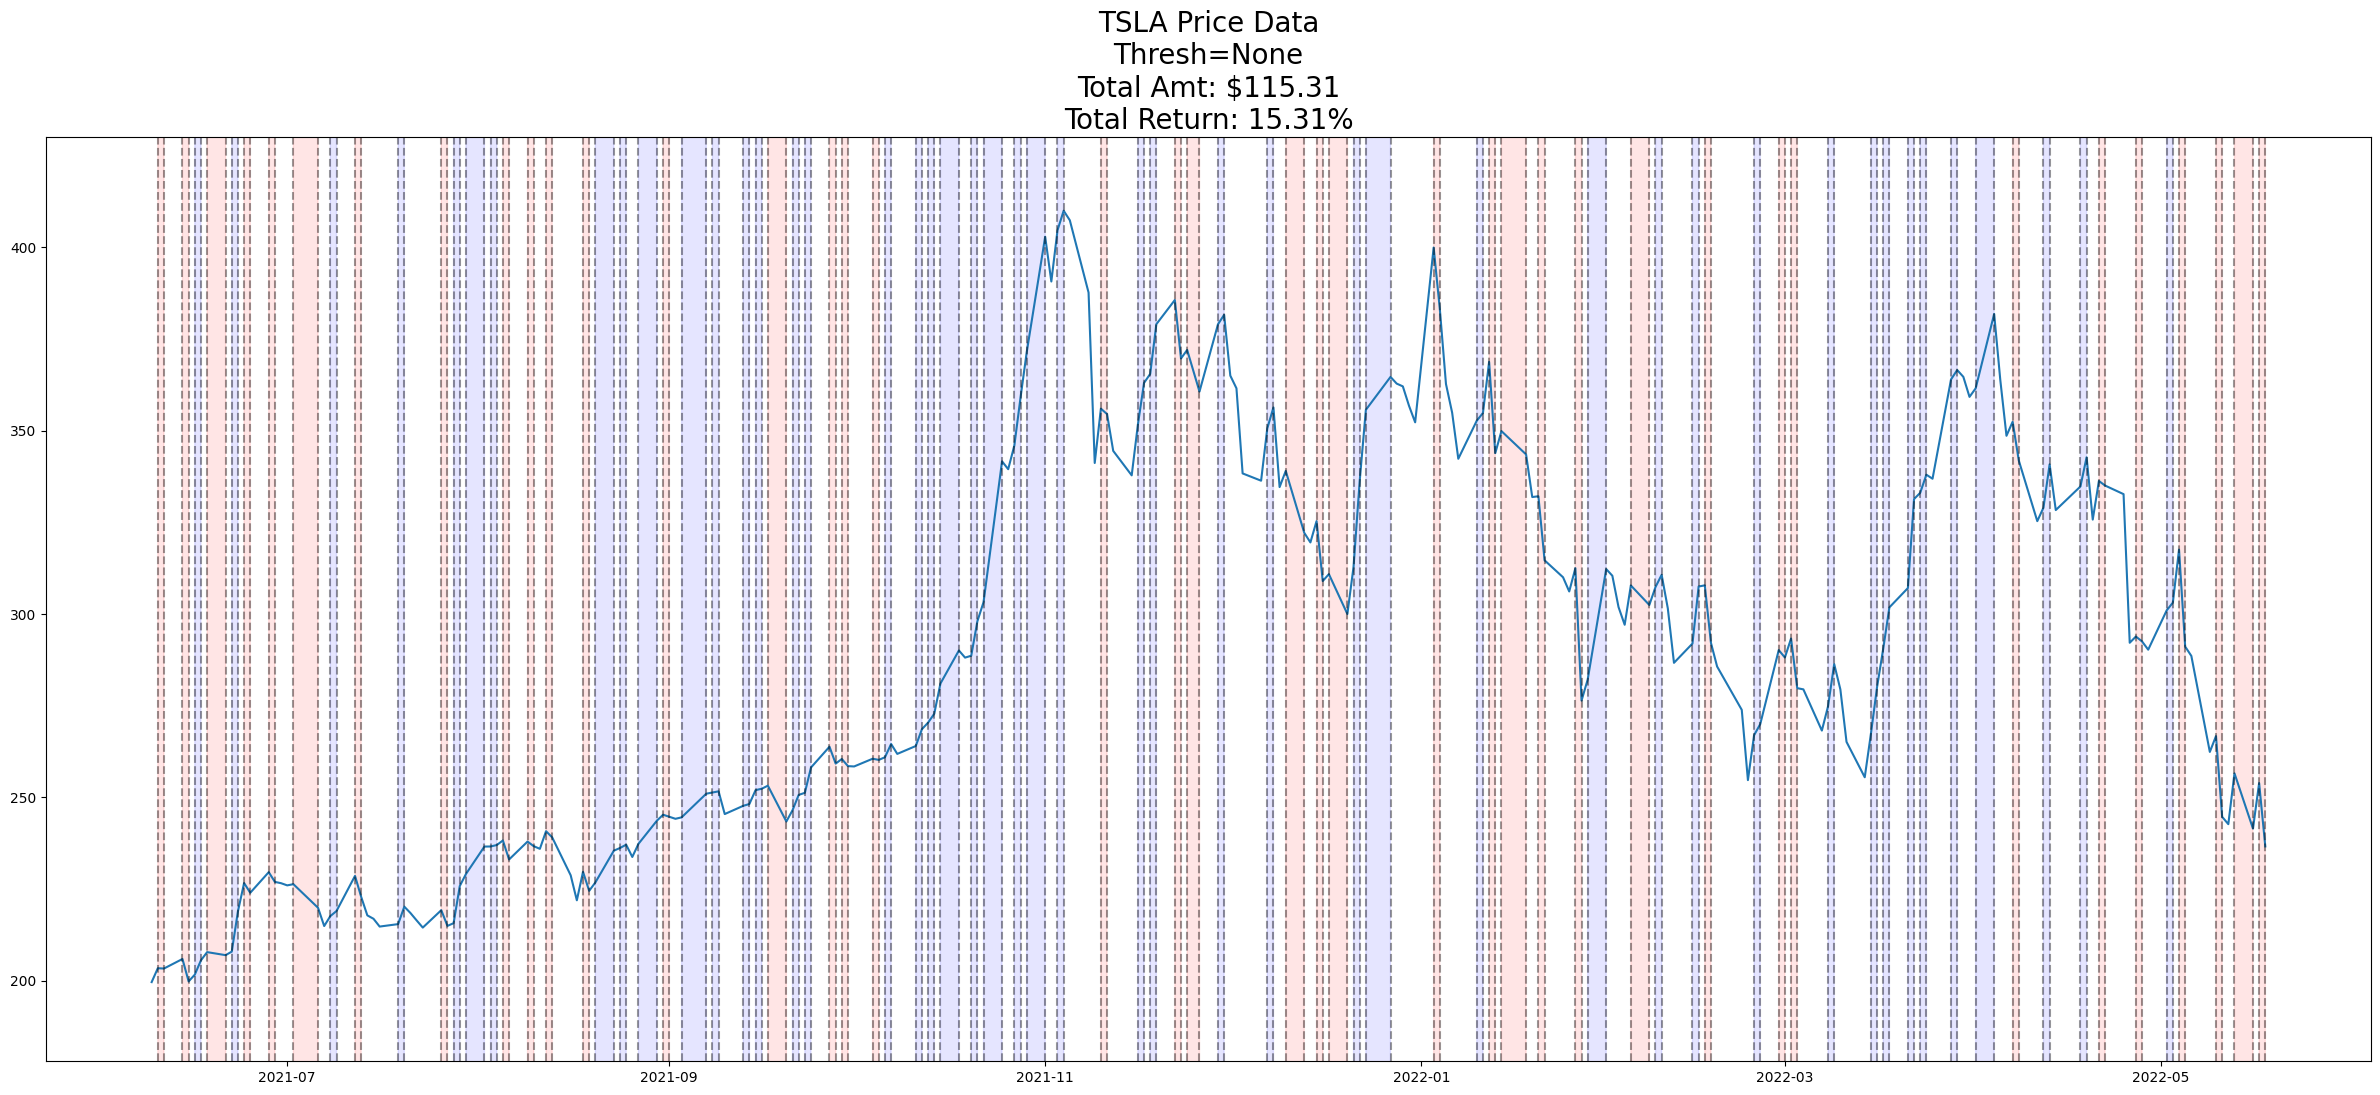

115.31388391942512

In [18]:
run_simulation(returns, prices, 100, 'last', None, verbose=False)

100%|██████████| 238/238 [00:00<00:00, 10649.30it/s]


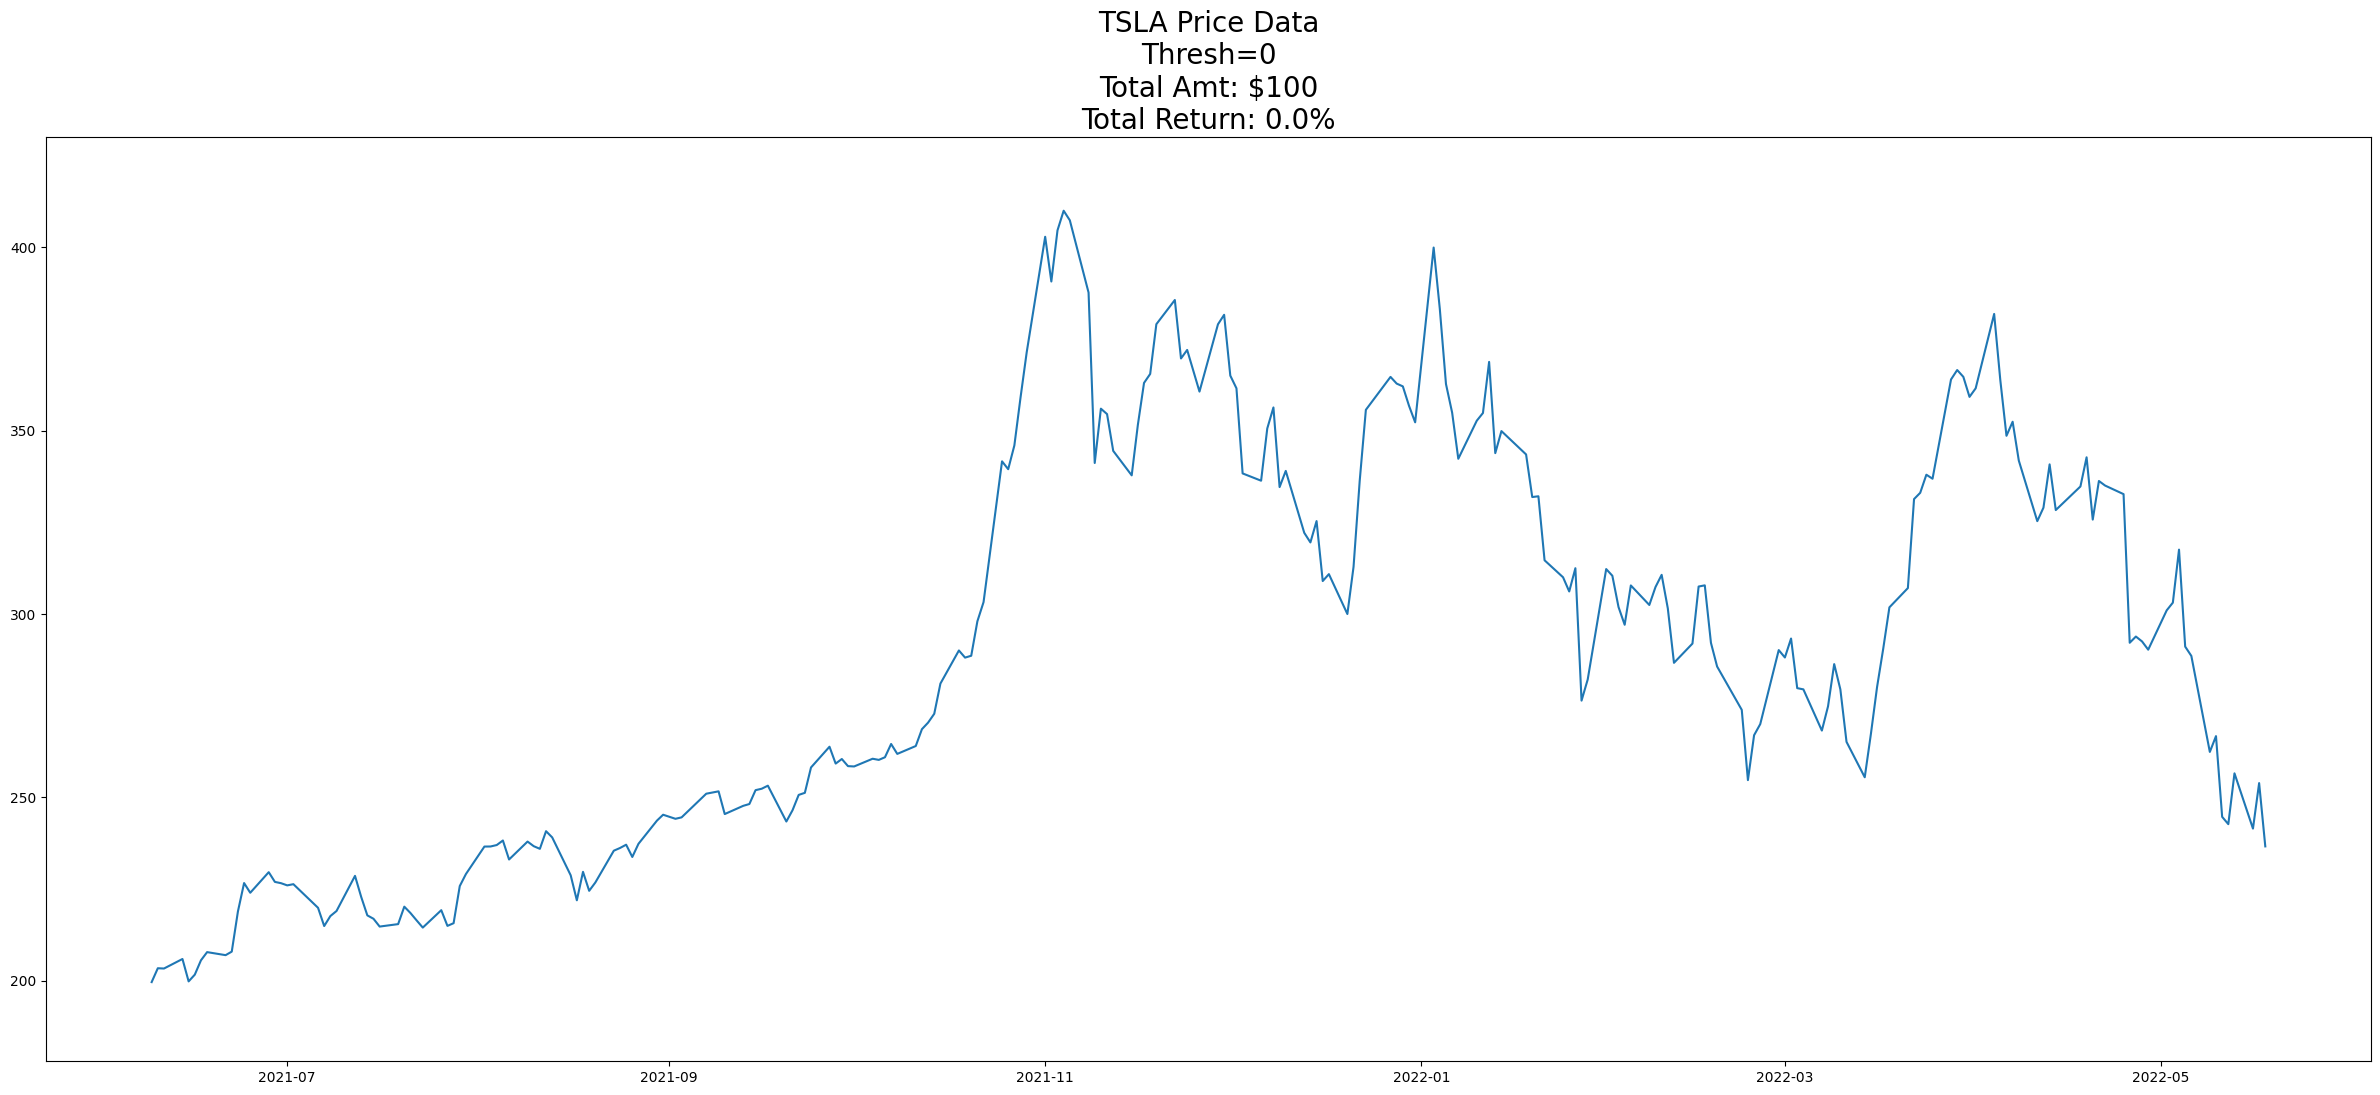

100%|██████████| 238/238 [00:00<00:00, 6632.50it/s]


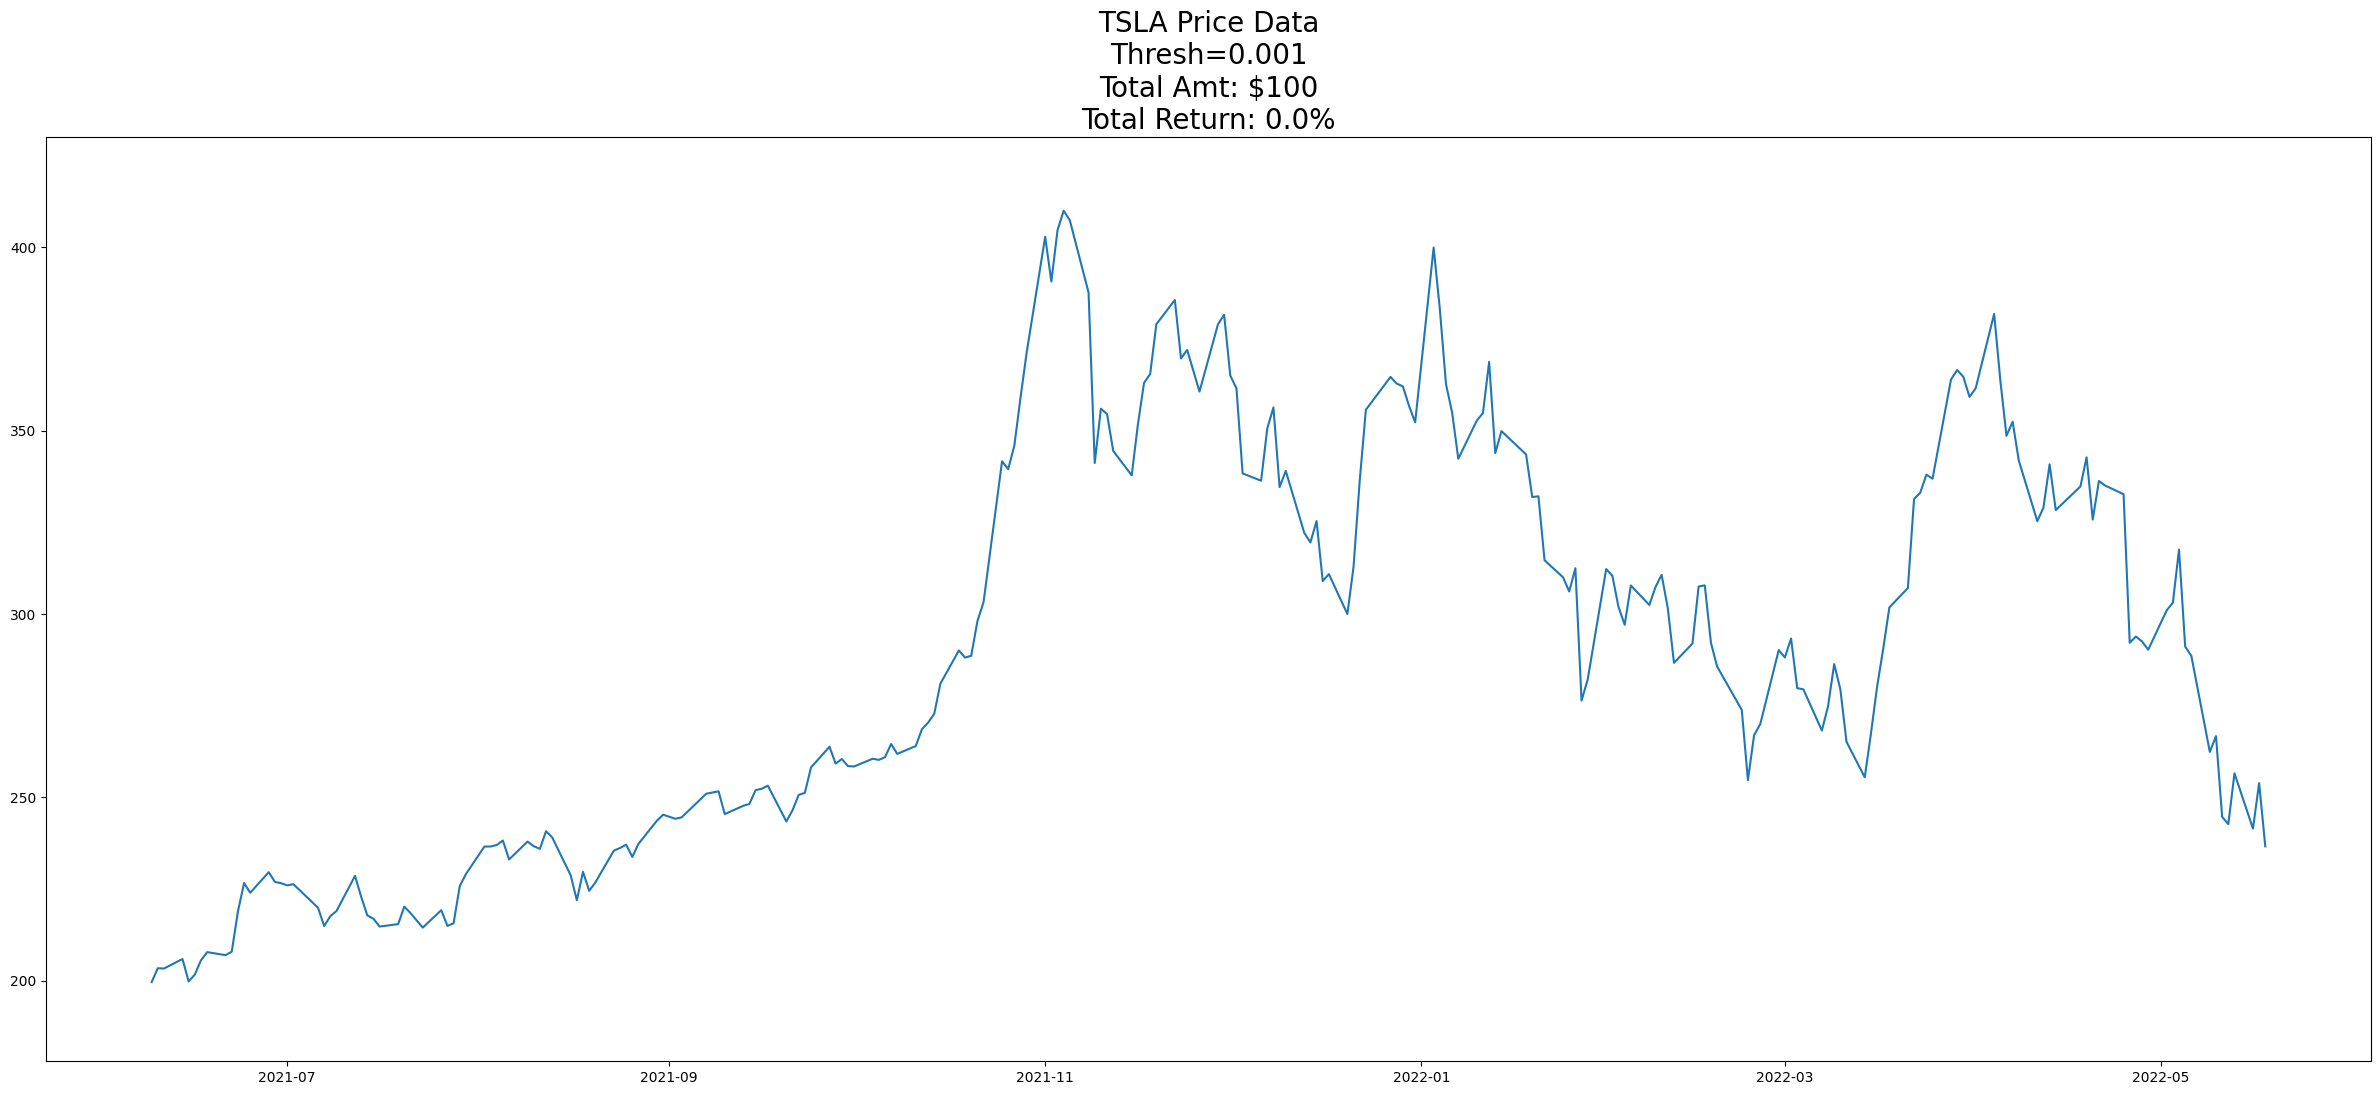

100%|██████████| 238/238 [00:00<00:00, 6596.47it/s]


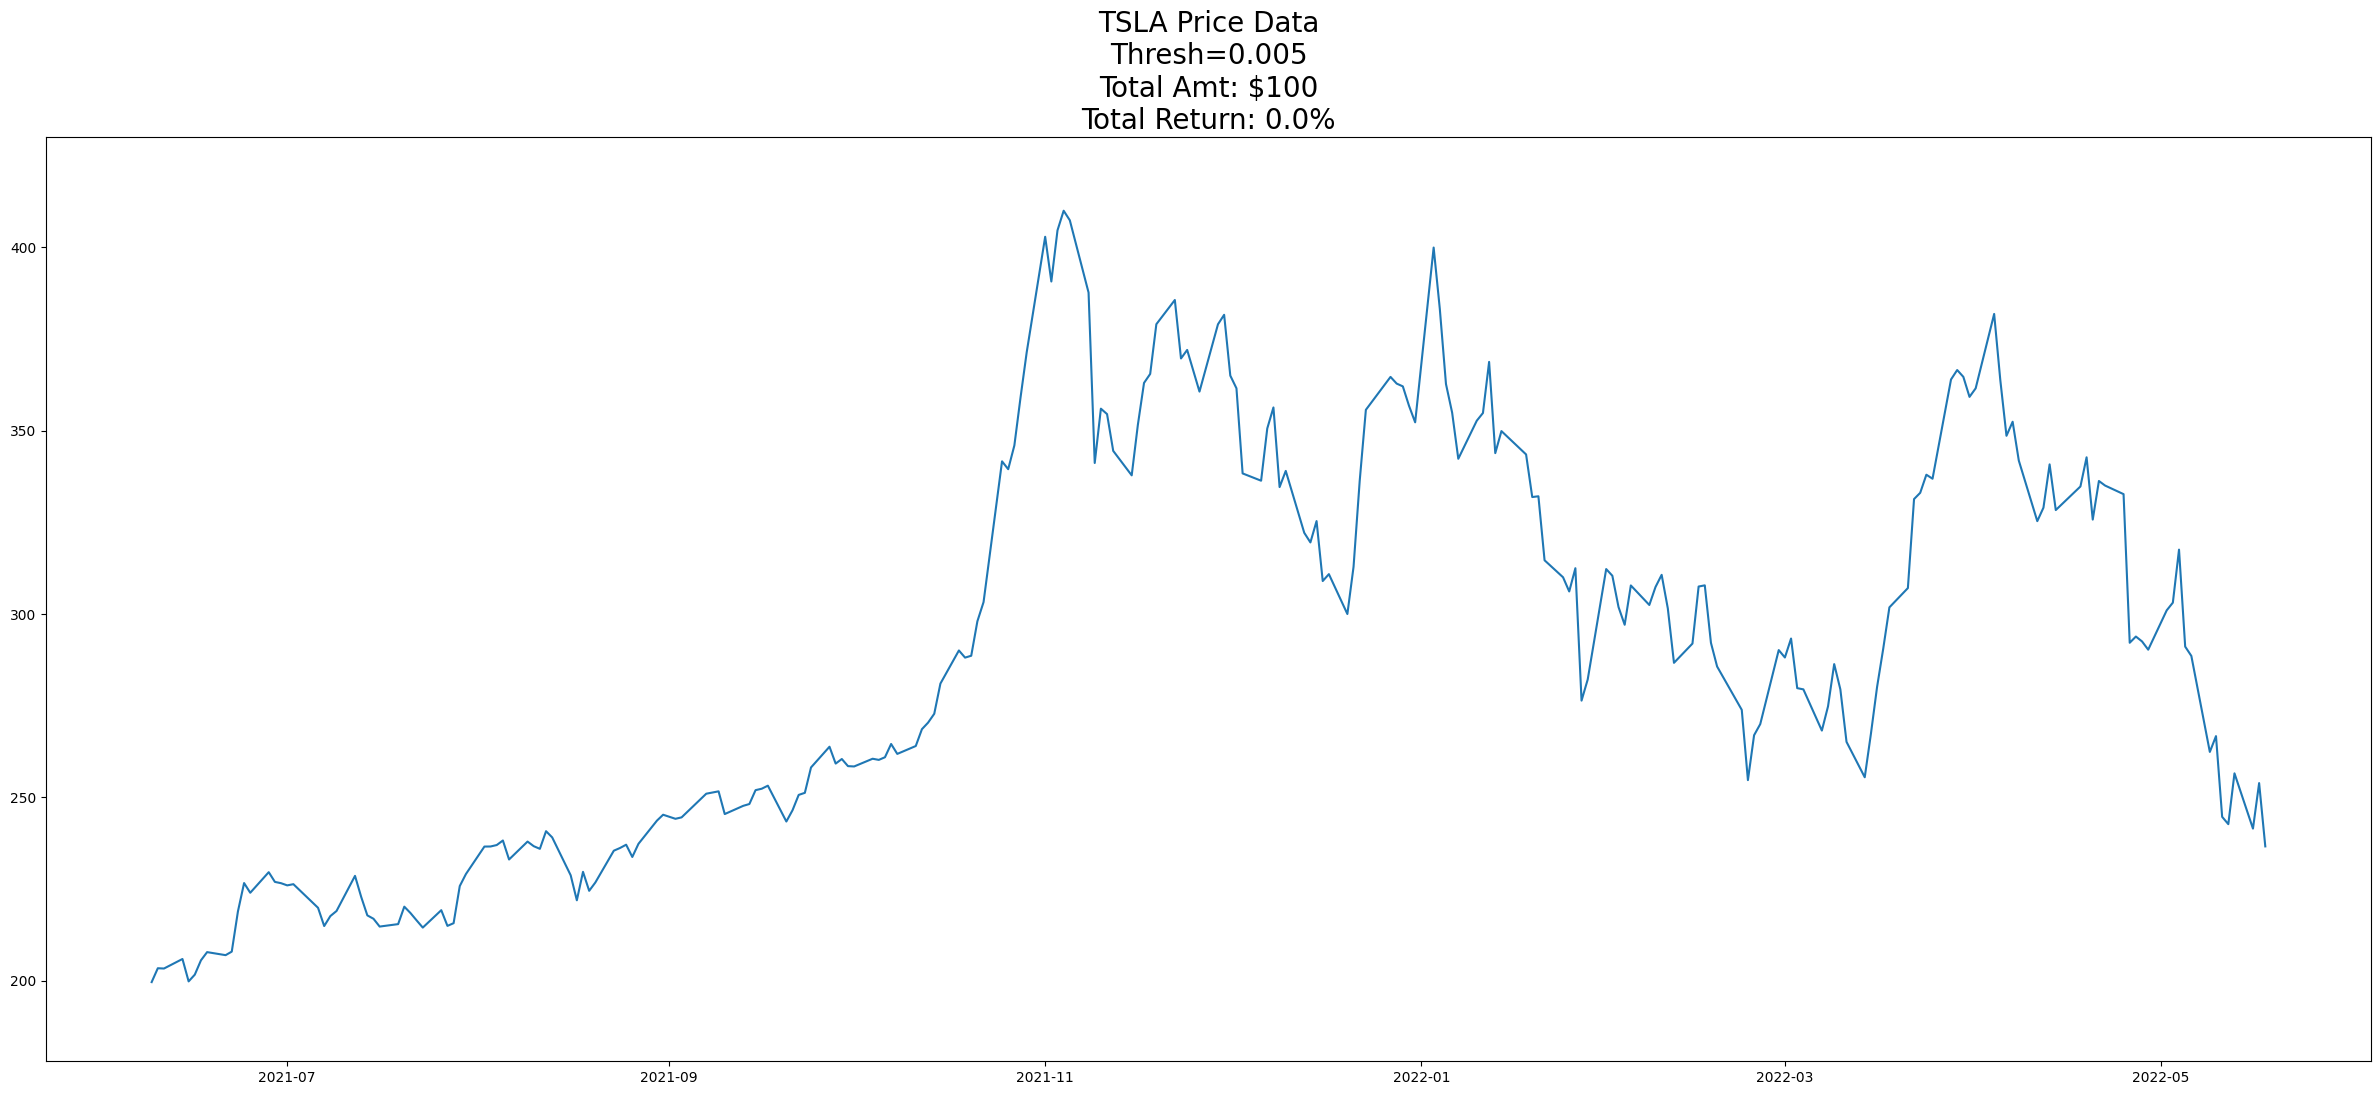

In [19]:
for thresh in [0, 0.001, 0.005]:
    run_simulation(returns, prices, 100, (1,0,0), thresh, verbose=False)

100%|██████████| 238/238 [00:00<00:00, 4871.55it/s]


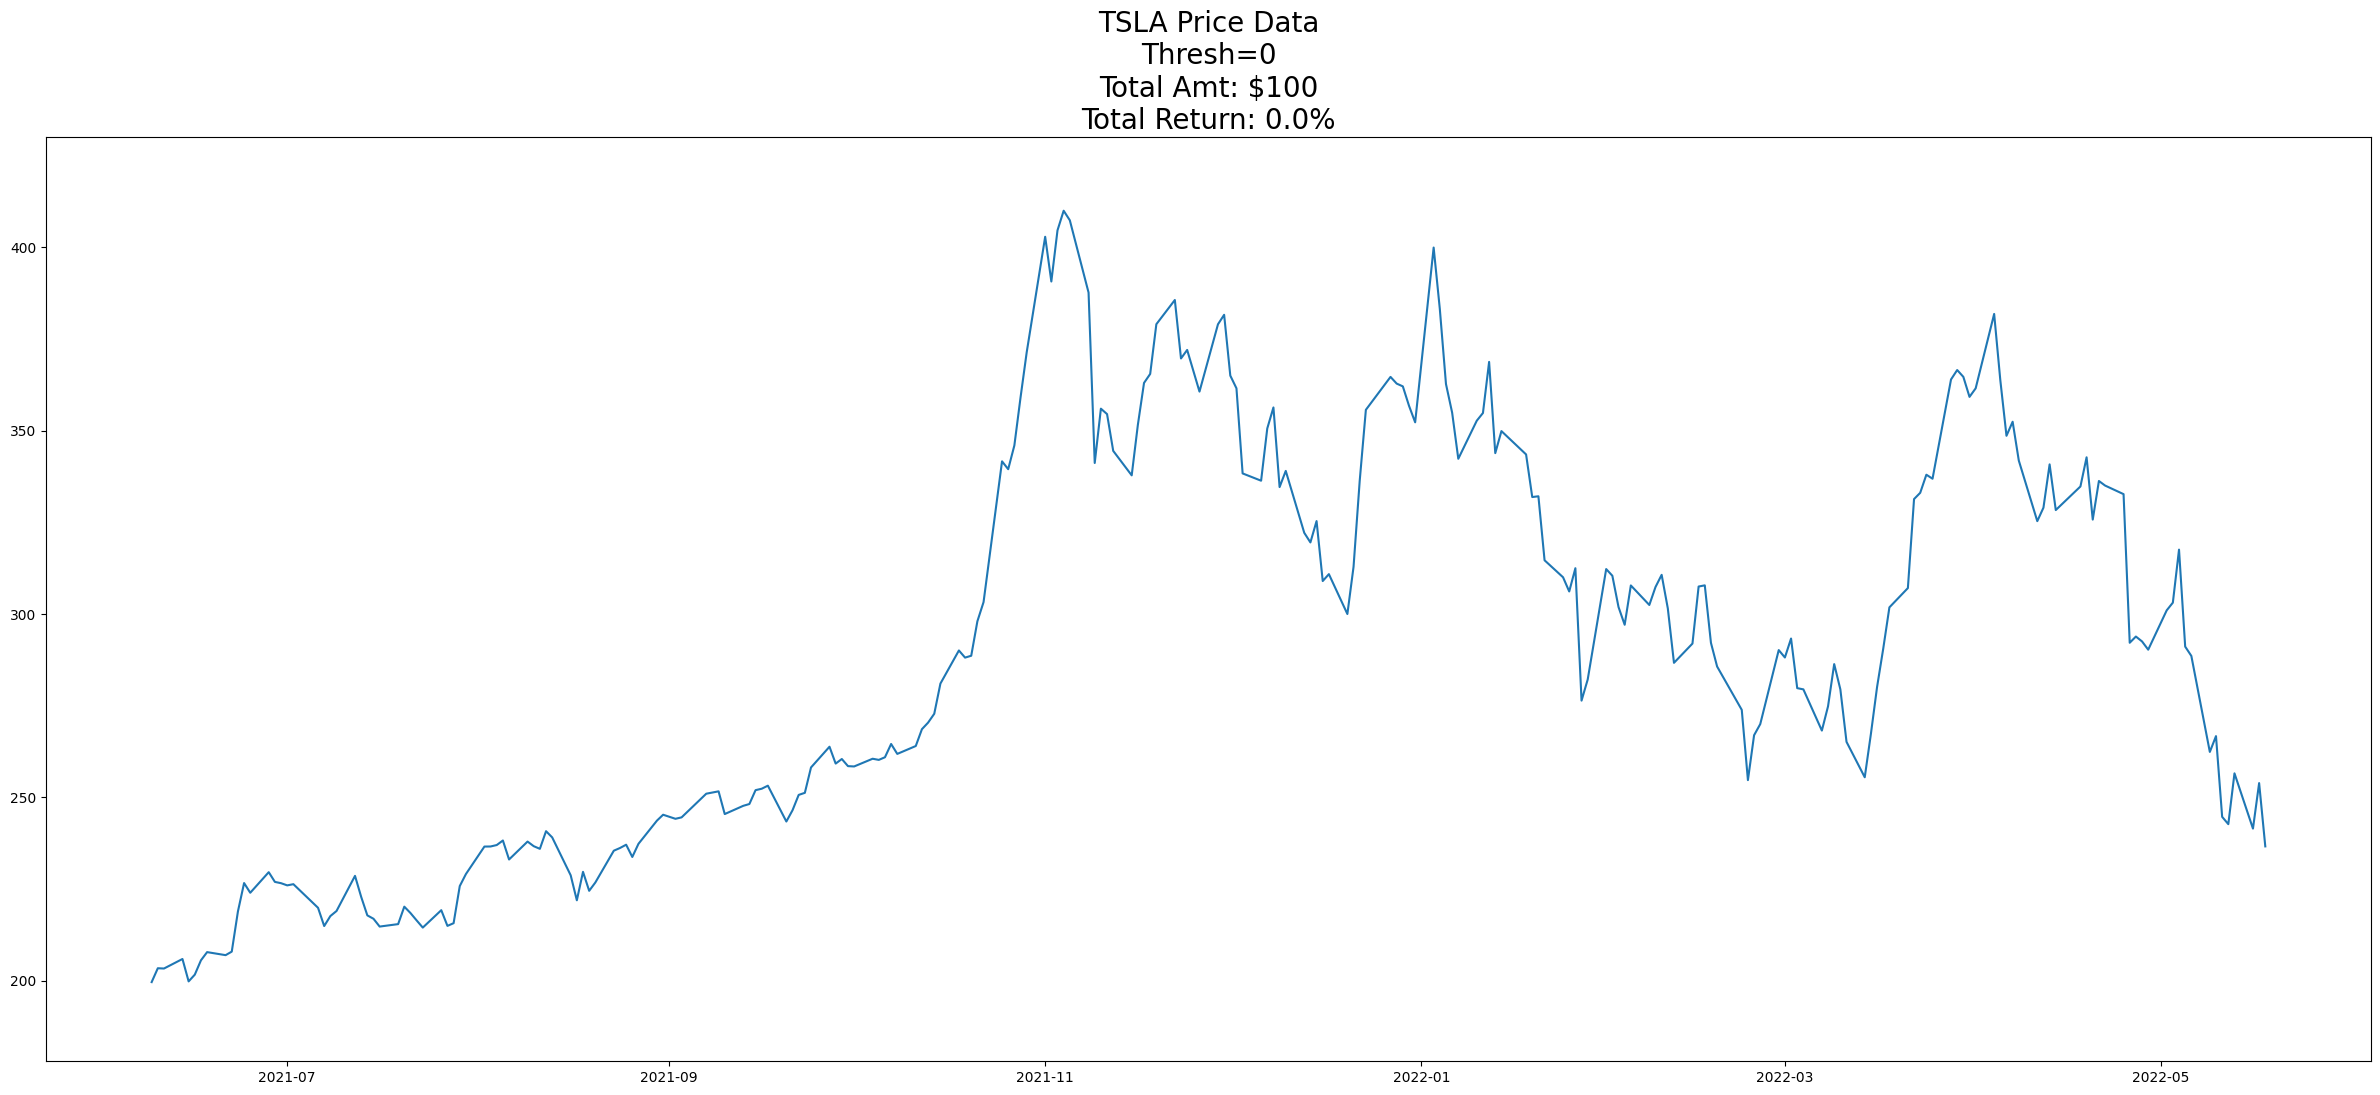

100%|██████████| 238/238 [00:00<00:00, 4525.09it/s]


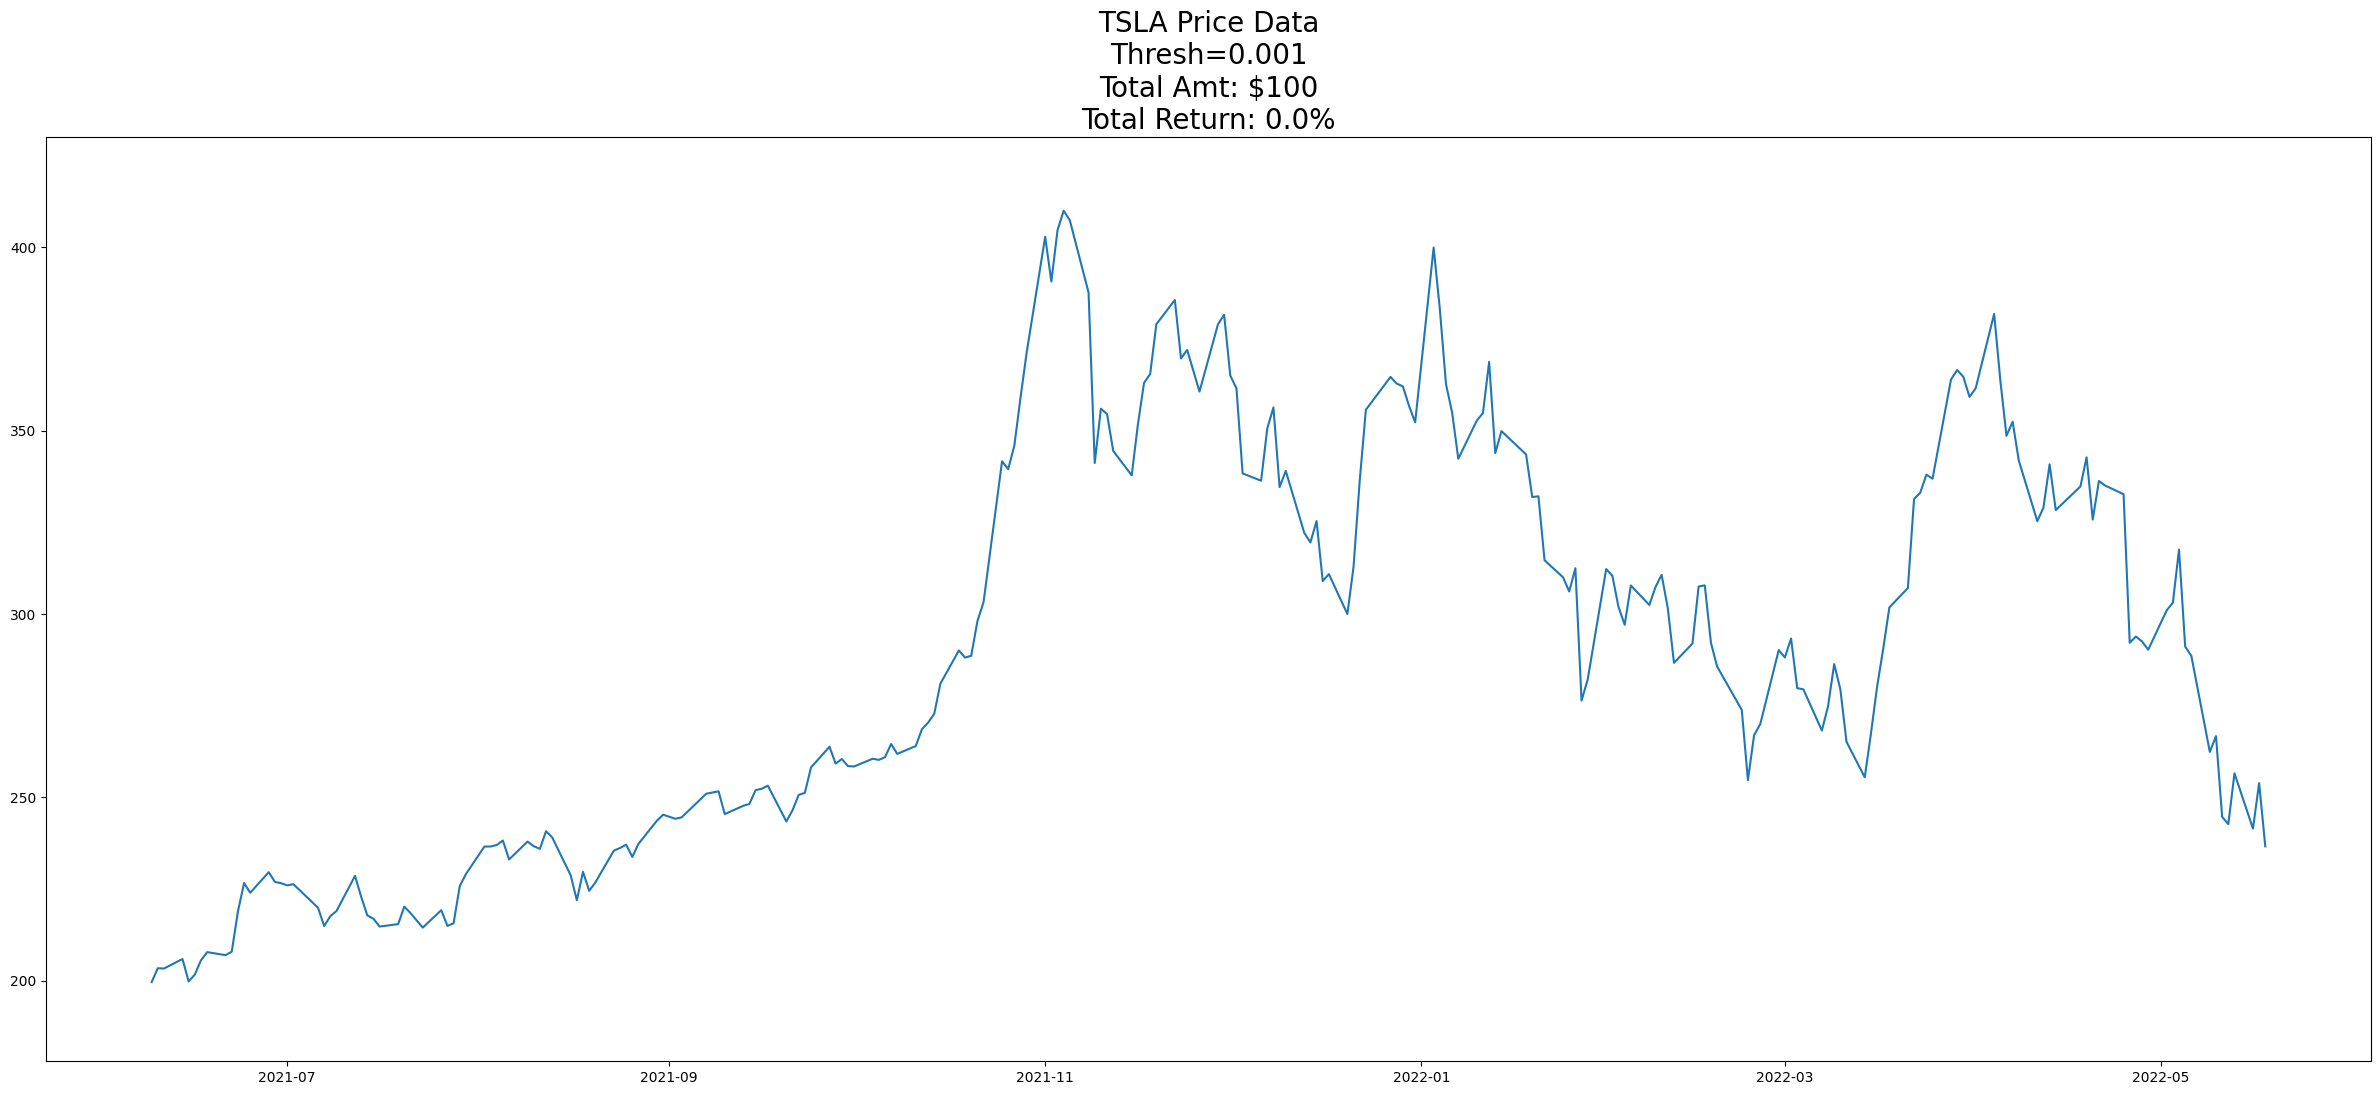

100%|██████████| 238/238 [00:00<00:00, 6414.26it/s]


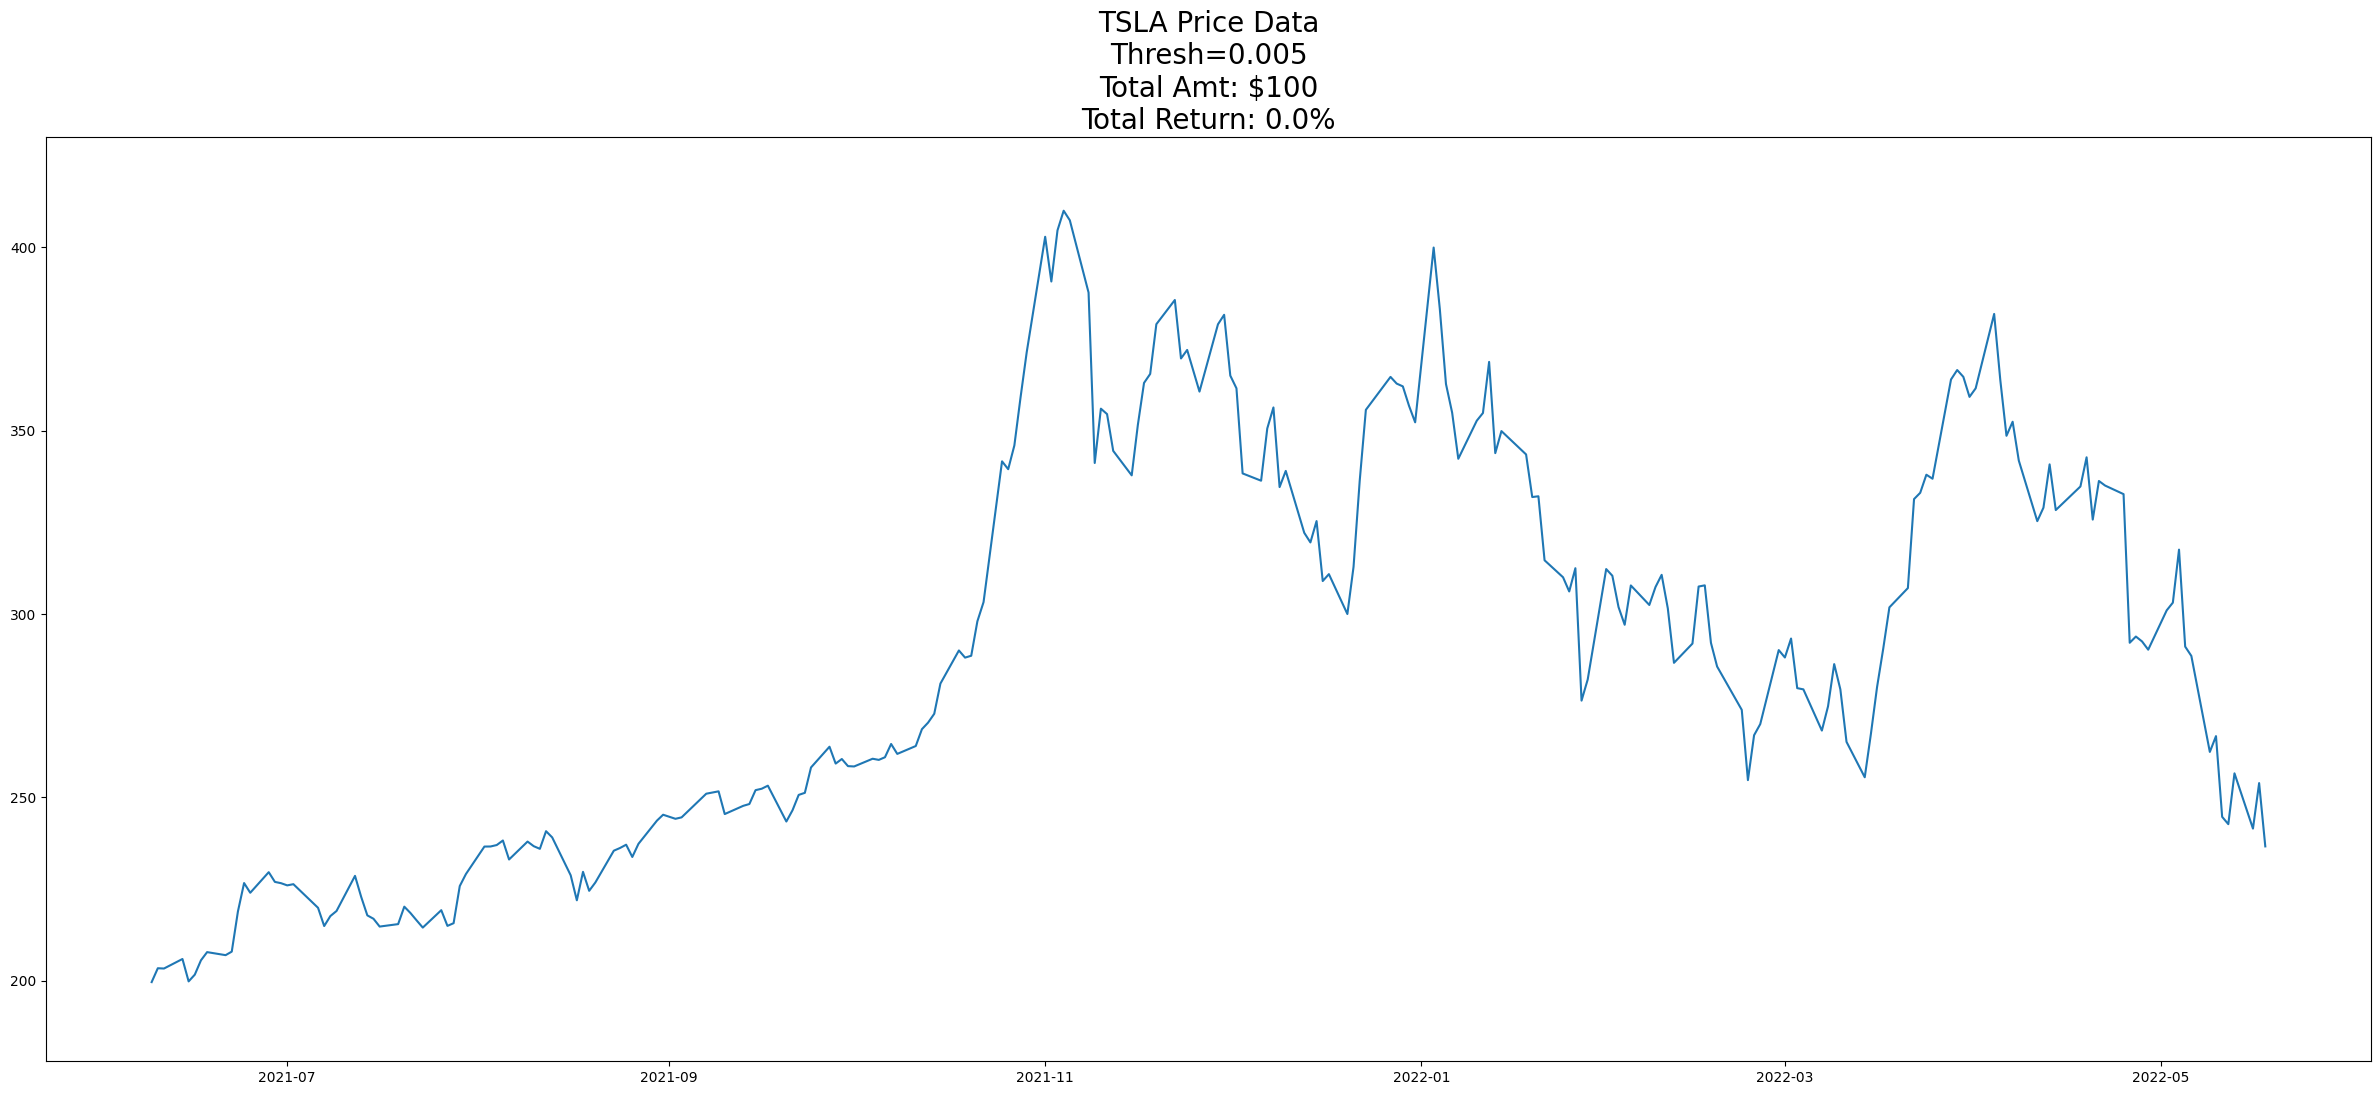

In [20]:
#x=7
for thresh in [0, 0.001, 0.005]:
    run_simulation(returns, prices, 100, (7,0,0), thresh, verbose=False)


100%|██████████| 238/238 [00:00<00:00, 4534.47it/s]


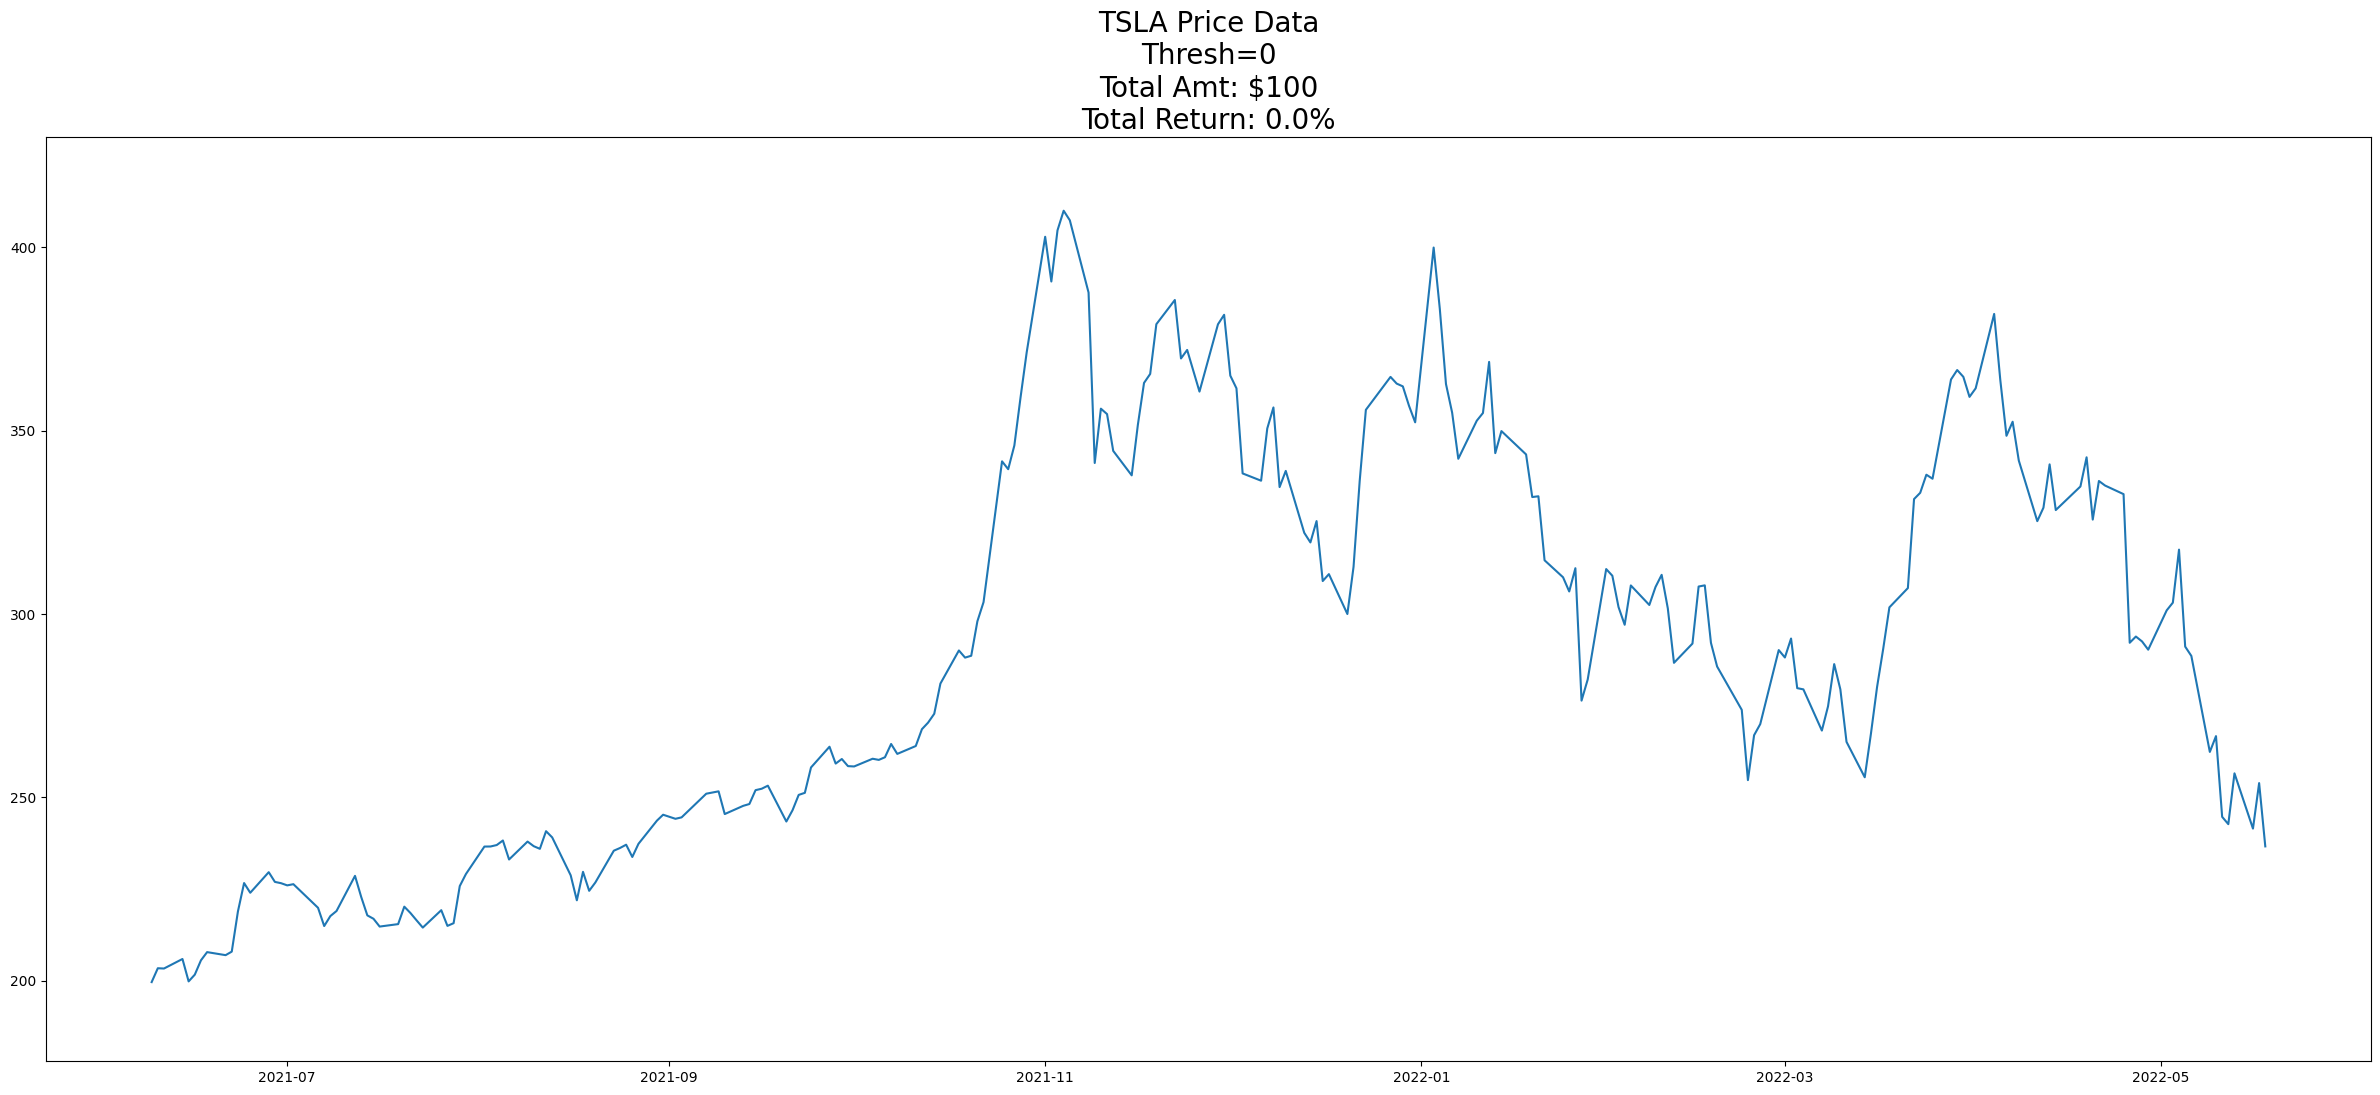

100%|██████████| 238/238 [00:00<00:00, 5564.82it/s]


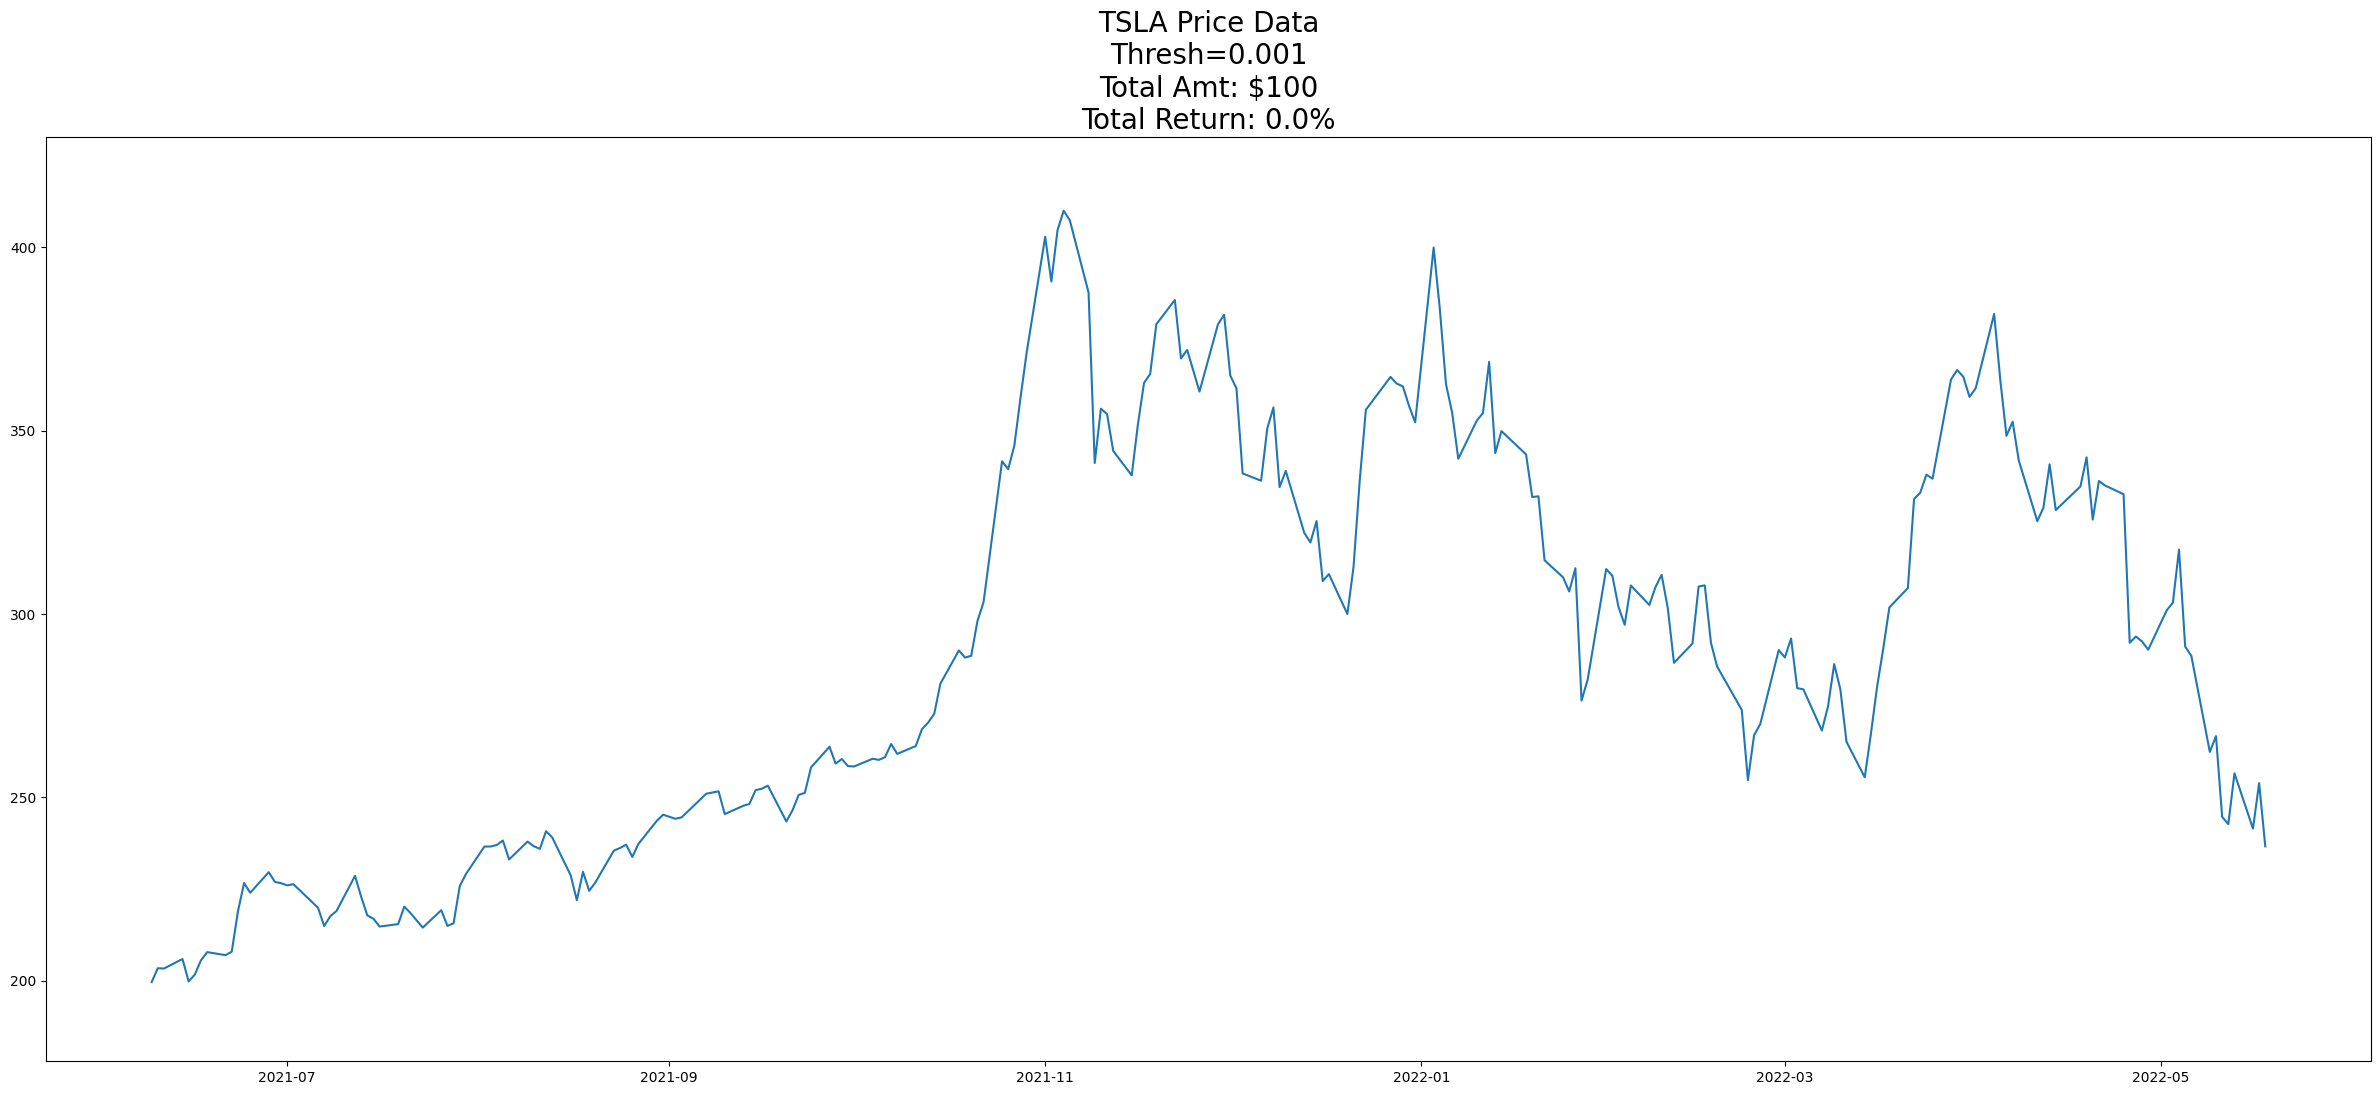

100%|██████████| 238/238 [00:00<00:00, 7064.37it/s]


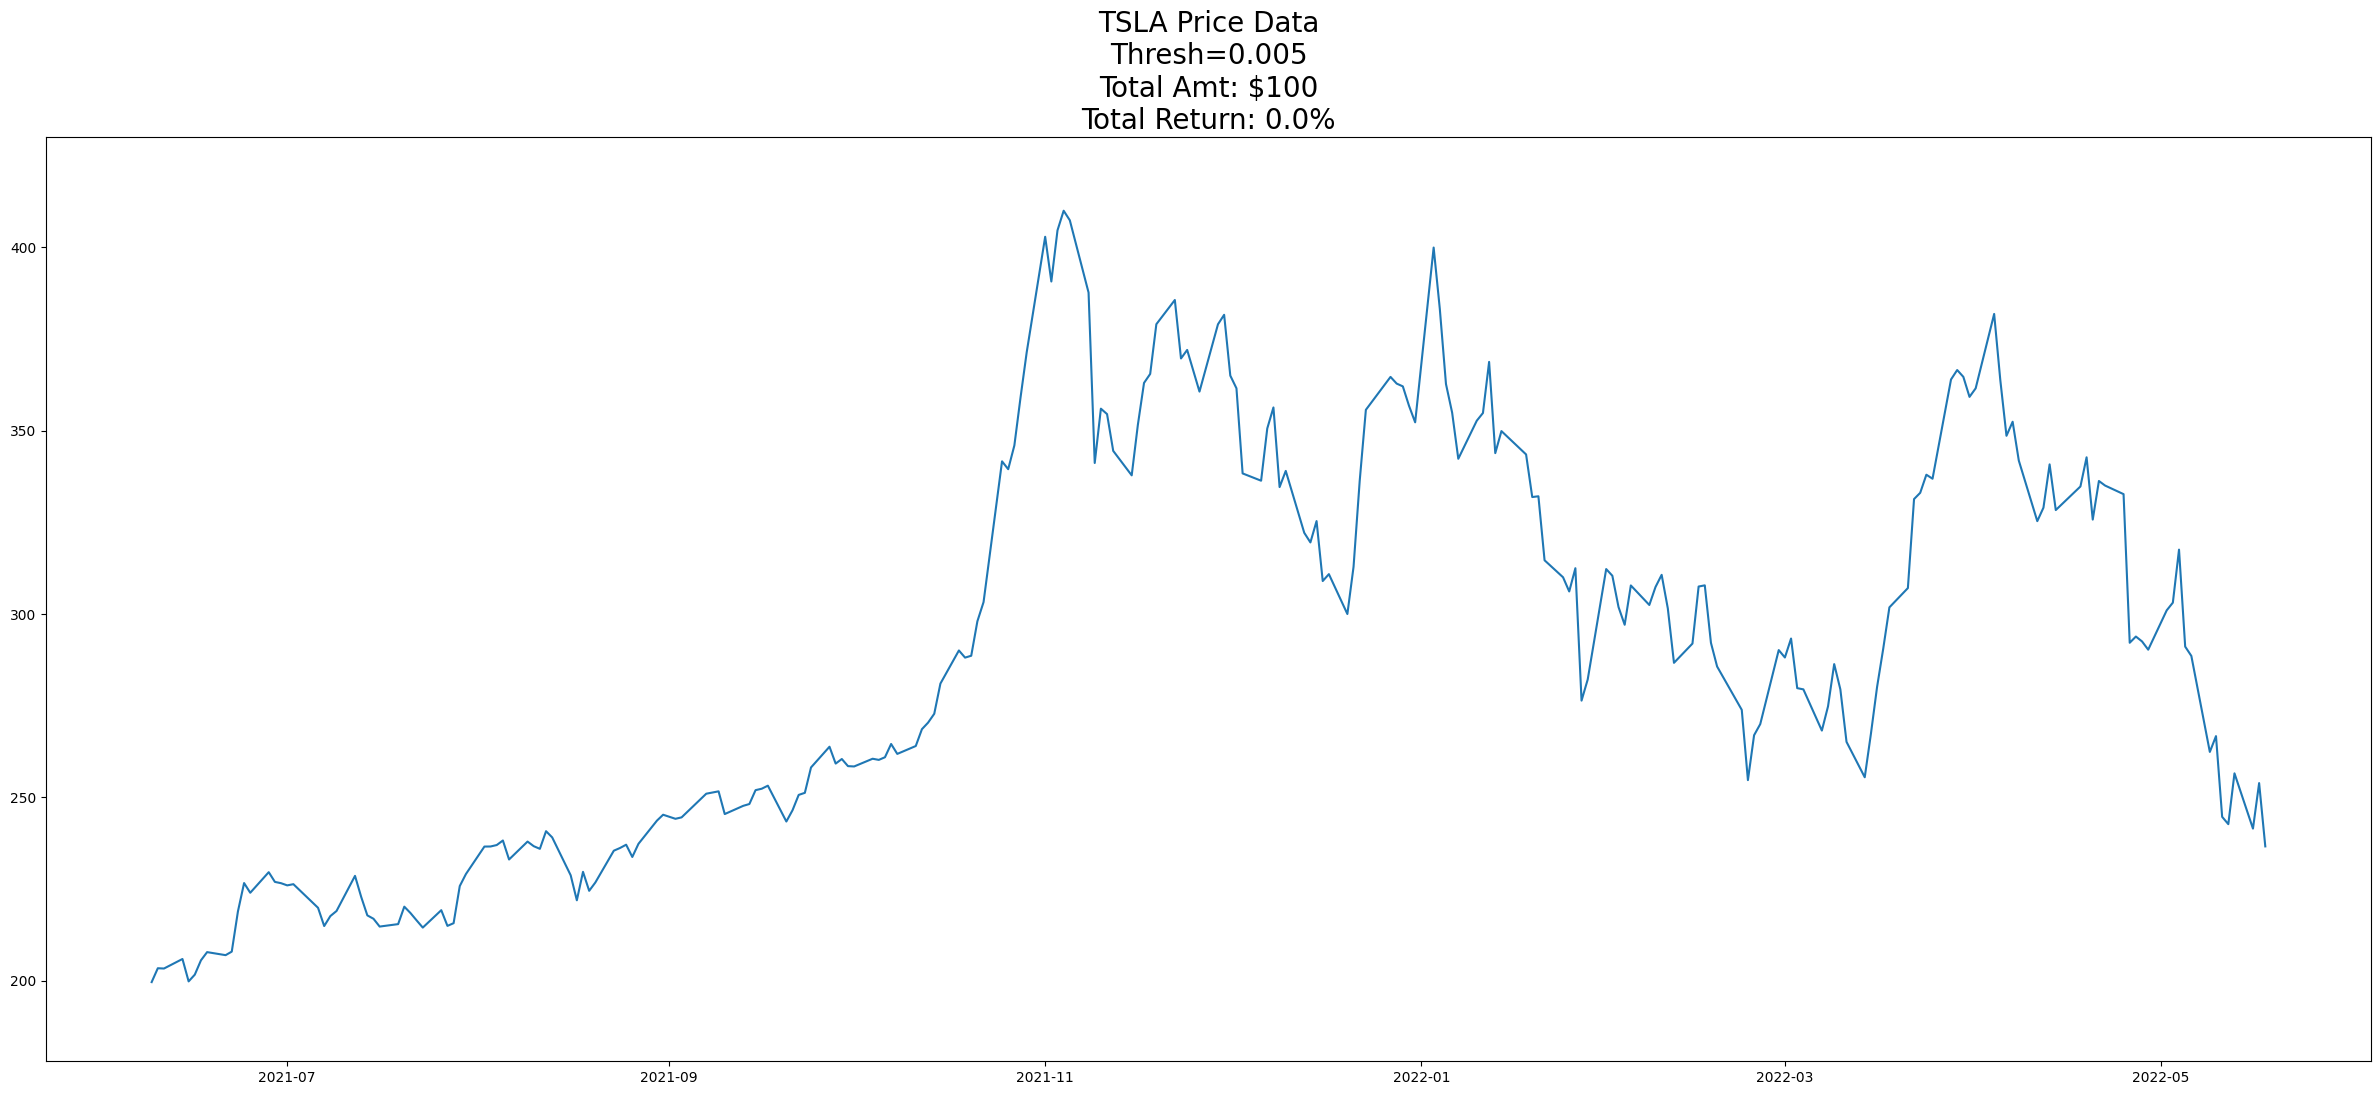

In [21]:
for thresh in [0, 0.001, 0.005]:
    run_simulation(returns, prices, 100, (7,0,7), thresh, verbose=False)